<a href="https://colab.research.google.com/github/msuribec/AppliedML_Python_Coursera/blob/master/Examen_admisi%C3%B3n_Maestria_Ciencia_de_datos_Maria_Sofia_Uribe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MARIA SOFIA URIBE


EXAMEN MAESTRIA DE CIENCIA DE DATOS

In [332]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style

import plotly.express as px
import seaborn as sns

style.use('ggplot') or plt.style.use('ggplot')
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Punto 1

Primero plantearemos la función ganancia según los datos que nos especifica el enunciado


Las variables son:
*   cf = Costos fijos = 500 mensuales
*   cu = Costo por unidad producida = 20 por unidad producida
*   p = precio de veta por unidad
*   q =   número de unidades que se venden = 200 - p


Así, la función de ganancias es


*   G(p) = Ventas - Costos
*   G(p) = número de unidades vendidas* precio de venta - costos fijos - costos variables
*   G(p) = q*p - cf - cu*q
*   G(p) =(200-p)*p - 500 - 20*(200-p)
*   G(p) = 200*p-p^2 -500 - 4000 + 20p
*   G(p) = 220*p-p^2 -4500

Para maximizar la función tomamos la derivada
*  G'(p) = 220-2p
Igualando a cero obtenemos
*  G'(p) = 220-2p = 0
por lo cual
*  p = 110

Probamos puntos críticos
*  G'(100) = 220-2*100=20>0
*  G'(230) = 220-2*230=-240<0

Comprobamos que el punto encontrado es un máximo y por tanto, el precio ideal para maximizar la ganancia sería de 110 dólares lo que generaría una ganancia de
G(110) = 220*p-p^2 -4500 = 7600 dólares





Implementamos la forma más simple del algoritmo de gradiente descendiente
en cada paso calculamos el gradiente del vector y multiplicamos por la tasa de aprendizaje

In [316]:
def gradient_descent(gradient, x0, lr, N=50, tol=1e-06):
    vector = x0
    for i in range(N):
        diff = -lr * gradient(vector)
        if np.all(np.abs(diff) <= tol):
            break
        vector += diff
    return vector

Para correr el algoritmo solo necesitamos el gradiente de la función a minimizar, un punto inicial y condiciones de parada.

Debido a que el gradiente descendiente es un algoritmo para minimizar, optaremos por minimizar el inverso aditivo de la función, ya que en este caso el problema de maximixación es equivalente, es decir:

Max G(p) = Min -G(p)

Así para calcular el gradiente debemos hallar -G'(p) que equivae a

G'(p) = 2p-220

Corremos el algoritmo con el gradiente y un punto inicial de 50 puesto que este es el precio de venta que está utilizando la empresa en este momento

In [324]:
p_opt = gradient_descent(gradient=lambda p: 2*p-220, x0=50, N=1000, lr=0.01, tol = 1e-9)
p_opt

109.99999989902197

El algoritmo arroja p = 109.99999989902197 lo que es una buena aproximación a la solución analítica que es 110 dólares

In [327]:
def ganancia(x):
  return (220*x-x**2 - 4500)
ganancia_optima = ganancia(p_opt)
ganancia_optima

7600.000000000002

In [339]:
p_opt

109.99999989902197

In [340]:
ganancia_optima

7600.000000000002

Verificamos que la ganancia máxma que se obtiene a partir del precio óptimo que se obtiene con el gradiente descendiente concuerda con el obtenido analíticamente

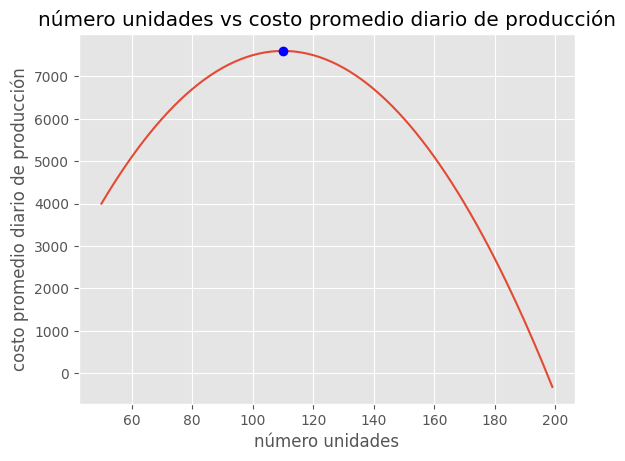

In [345]:
x = np.arange(50,200)
y = ganancia(x)
plt.plot(x, y)
plt.plot(p_opt,ganancia_optima, 'ro', color = 'blue')
plt.title('número unidades vs costo promedio diario de producción')
plt.xlabel('número unidades')
plt.ylabel('costo promedio diario de producción')
plt.show()

Al graficar la función observamos que efectivamente el punto que hemos encontrado es un máximo

# Punto 2

In [346]:
electric_usage = pd.read_csv('ElectricityUsage.csv')
electric_usage.head()

,Temperature,Electricity_Usage
0,24.36,1435.41
1,38.77,2078.70
2,33.30,1883.35
3,29.97,1300.99
4,18.90,1101.07


In [48]:
electric_usage

,Temperature,Electricity_Usage
0,24.36,1435.41
1,38.77,2078.70
2,33.30,1883.35
3,29.97,1300.99
4,18.90,1101.07
...,...,...
95,27.34,1403.84
96,28.07,1588.08
97,25.69,1552.73
98,15.64,1037.34


Sacamos una muestra de 50 observaciones

In [55]:
size_muestra = 50
muestra = electric_usage.iloc[0:size_muestra].values
ones = np.ones([size_muestra,1])

In [347]:
temperatura_muestra = muestra[:,0]
temperatura_muestra

array([24.36, 38.77, 33.3 , 29.97, 18.9 , 18.9 , 16.45, 36.65, 30.03,
       32.7 , 15.51, 39.25, 35.81, 20.31, 19.55, 19.59, 22.61, 28.12,
       25.8 , 22.28, 30.3 , 18.49, 22.3 , 24.16, 26.4 , 34.63, 19.99,
       27.86, 29.81, 16.16, 30.19, 19.26, 16.63, 38.72, 39.14, 35.21,
       22.62, 17.44, 32.11, 26.  , 18.05, 27.38, 15.86, 37.73, 21.47,
       31.56, 22.79, 28.  , 28.67, 19.62])

Construimos las matrices X y Y a partir de la muestra. X es una matriz 50x2 donde la primera columna son unos y la segunda es la variable independiente (temperatura)
La matriz Y es una matriz 50x2 con la variable dependiente (consumo de electricidad)

In [351]:
X = np.column_stack((ones, temperatura_muestra))
Y = muestra[:,1]

In [352]:
X.shape

(50, 2)

In [353]:
Y.shape

(50,)

Calculamos beta a partir de la ecuación normal, esto nos arroja los coeficientes de la línea recta

In [349]:
Beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [350]:
Beta

array([484.27390611,  39.27508945])

vemos que β0 = 484.27390611 y β1 = 39.27508945
por lo que la línea recta está dada por


Y = 484.274+39.27*X

Ajustamos la recta con los datos de entrenamiento y graficamos

In [61]:
X_train = muestra[:,0]
Y_train = muestra[:,1]

Y_ajustada = Beta[0]+Beta[1]*X_train

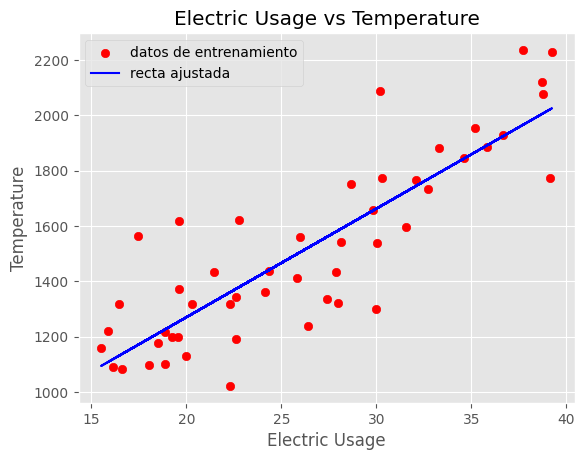

In [63]:
plt.scatter(X_train, Y_train, color = 'red', label = 'datos de entrenamiento')
plt.plot(X_train, Y_ajustada, color = 'blue', label = 'recta ajustada')
plt.title('Electric Usage vs Temperature')
plt.xlabel('Electric Usage' )
plt.ylabel('Temperature')
plt.legend()
plt.show()

Sacamos las siguientes 50 observaciones como un dataset de prueba

In [354]:
índice = 50
test_set = electric_usage.iloc[índice:].values

In [68]:
test_set

array([[  39.24, 1963.89],
       [  34.38, 1805.74],
       [  38.49, 2144.43],
       [  37.37, 1967.8 ],
       [  29.95, 1387.37],
       [  38.05, 2116.21],
       [  17.21,  848.04],
       [  19.9 , 1289.72],
       [  16.13,  822.62],
       [  23.13, 1666.49],
       [  24.72, 1279.35],
       [  21.78, 1224.59],
       [  35.72, 2148.7 ],
       [  23.92, 1149.83],
       [  22.02, 1346.49],
       [  28.57, 1889.93],
       [  18.52,  804.5 ],
       [  35.05, 1989.43],
       [  16.86, 1094.98],
       [  39.67, 2339.86],
       [  34.31, 1668.11],
       [  19.97,  934.41],
       [  15.14, 1061.39],
       [  35.39, 2028.9 ],
       [  32.67, 1883.6 ],
       [  33.23, 1930.79],
       [  34.28, 1778.  ],
       [  16.85, 1088.95],
       [  23.96, 1456.61],
       [  17.9 ,  952.13],
       [  36.58, 2402.15],
       [  30.58, 1823.77],
       [  23.27, 1125.24],
       [  16.59, 1160.81],
       [  22.77, 1143.56],
       [  23.13, 1513.92],
       [  33.24, 2093.72],
 

In [355]:
test_set.shape

(50, 2)

In [356]:
X_test = test_set[:,0]

In [357]:
X_test

array([39.24, 34.38, 38.49, 37.37, 29.95, 38.05, 17.21, 19.9 , 16.13,
       23.13, 24.72, 21.78, 35.72, 23.92, 22.02, 28.57, 18.52, 35.05,
       16.86, 39.67, 34.31, 19.97, 15.14, 35.39, 32.67, 33.23, 34.28,
       16.85, 23.96, 17.9 , 36.58, 30.58, 23.27, 16.59, 22.77, 23.13,
       33.24, 30.94, 37.18, 26.81, 17.99, 32.83, 34.02, 29.03, 34.27,
       27.34, 28.07, 25.69, 15.64, 17.7 ])

Hacemos las predicciónes de acuerdo a los coeficientes encontrados anteriormente

In [358]:
X_test = test_set[:,0]
Y_real = test_set[:,1]
Y_predict = Beta[0]+Beta[1]*X_test

In [359]:
Y_predict

array([2025.42841603, 1834.55148131, 1995.97209894, 1951.98399876,
       1660.56283506, 1978.69105959, 1160.1981955 , 1265.84818611,
       1117.7810989 , 1392.70672503, 1455.15411725, 1339.68535428,
       1887.18010117, 1423.73404569, 1349.11137574, 1606.36321162,
       1211.64856268, 1860.86579124, 1146.45191419, 2042.31670449,
       1831.80222505, 1268.59744238, 1078.89876034, 1874.21932166,
       1767.39107836, 1789.38512845, 1830.62397237, 1146.0591633 ,
       1425.30504927, 1187.29800722, 1920.9566781 , 1685.30614141,
       1398.20523755, 1135.84764004, 1378.56769283, 1392.70672503,
       1789.77787934, 1699.44517361, 1944.52173177, 1537.2390542 ,
       1190.83276527, 1773.67509267, 1820.41244911, 1624.42975277,
       1830.23122147, 1558.0548516 , 1586.7256669 , 1493.25095402,
       1098.53630507, 1179.44298933])

Encontramos el MSE que en este caso es de 41013.

In [364]:
mse = np.mean((Y_real - Y_predict)**2)
mse

41013.16070013815

Ahora graficamos el conjunto de datos de prueba frenta a la recta ajustada (predicciones)

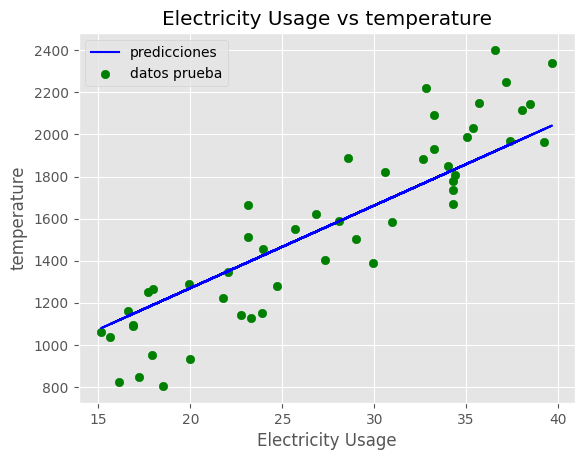

In [365]:
plt.plot(X_test, Y_predict, color = 'blue', label = 'predicciones')
plt.scatter(X_test, Y_real, color = 'green', label = 'datos prueba')
plt.title('Electricity Usage vs temperature')
plt.xlabel('Electricity Usage')
plt.ylabel('temperature')
plt.legend()
plt.show()

# Punto 3

In [86]:
OlympicSprintersTimes = pd.read_csv('OlympicSprintersTimes.csv')
OlympicSprintersTimes.head()

,Sprinter,Time (s)
0,Sprinter 1,10.32
1,Sprinter 2,9.58
2,Sprinter 3,9.85
3,Sprinter 4,9.90
4,Sprinter 5,9.90


In [366]:
sorted_times = OlympicSprintersTimes.sort_values(by=['Time (s)'], ascending= False)
sorted_times

,Sprinter,Time (s)
38,Sprinter 39,10.37
0,Sprinter 1,10.32
39,Sprinter 40,10.32
37,Sprinter 38,10.30
21,Sprinter 22,10.26
48,Sprinter 49,10.25
30,Sprinter 31,10.22
49,Sprinter 50,10.22
46,Sprinter 47,10.19
40,Sprinter 41,10.18


Organizando los datos del más lento al más rápido vemos que el más lento es el sprinter 39 que tarda 10.37 segundos mientras que el más rápido es el sprinter 44 que tarda solo 9.51 segundos

In [367]:
OlympicSprintersTimes.describe()

,Time (s)
count,50.0000
mean,9.9456
std,0.2348
min,9.5100
25%,9.7925
50%,9.9400
75%,10.1125
max,10.3700


In [368]:
olympic_sprinters_times = OlympicSprintersTimes['Time (s)'].values

In [369]:
median = OlympicSprintersTimes['Time (s)'].quantile(0.5)
primercuartil = OlympicSprintersTimes['Time (s)'].quantile(0.25)
tercercuartil = OlympicSprintersTimes['Time (s)'].quantile(0.75)
median,primercuartil,tercercuartil

(9.94, 9.7925, 10.112499999999999)



*   La mediana es de 9.94 segundos por lo que el 50% de los tiempos de los sprinters están por debajo de 9.94 segundos
*  El primer cuartil es 9.7925 segundos por lo que inferimos que el 25% de los tiempos están por debajo de 9.7925 segundos
*  El tercer cuartil es 10.1125 segundos por lo que inferimos que el 75% de los tiempos están por debajo de 10.1125 segundos

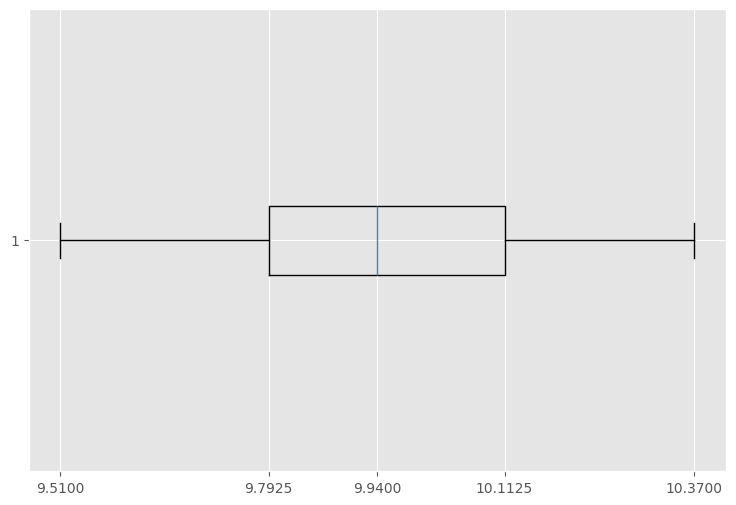

In [370]:

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

ax.boxplot(olympic_sprinters_times, vert=False, manage_ticks=True)
ax.set_yticks([1])

quantiles = np.quantile(olympic_sprinters_times, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.show()

En el boxplot podemos ver que no hay datos más allá de las barras del Q1-1.5IQR y Q3+1.5IQR por lo que con este método gráfico no podemos identificar outliers

Si nuestra población fueran todos los atletas profesionales que compiten en 100 metros planos entonces, los datos anteriores serían una muestra de pesos puesto que se trata de un subconjunto de todos los atletas que compiten en la prueba de 100m. Específicamente sería el subconjunto que pasó a la final.

Si nuestra población fueran solo finalistas olímpicos de la prueba de 100 metros planos entonces los datos anteriores serían la población puesto que se trata del conjunto completo.

Al utilizar el método de rango intercuartílico programado por nosotros confirmamos que mediante este método no identificamos outliers puesto que la cota inferior es de 9.3125 segundos y la cota superior es de 10.5925 segundos y no hay registros menores a 9.3 ni mayores a 10.5

In [107]:

def iqr_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    data_without_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
    return data_without_outliers,outliers, lower_bound, upper_bound

list_sin_outliers = []
list_outliers = []
list_lower_bound = []
list_upper_bound = []

In [371]:
data_without_outliers,outliers, lower_bound, upper_bound = iqr_outliers(olympic_sprinters_times)

In [372]:
lower_bound,upper_bound

(9.312500000000004, 10.592499999999998)

In [373]:
outliers

array([], dtype=float64)

Si asumimos que la población son los finalistas olímpicos entonces la media poblacional son 9.9456 segundos para terminar la prueba de 100m planos y la desviación estándar es de 0.2348 segundos

In [134]:
mean = OlympicSprintersTimes['Time (s)'].mean()
mean

9.9456

La media del conjunto es de 9.9456 segundos

In [115]:
std = OlympicSprintersTimes['Time (s)'].std()
std

0.2348004797825644

La desviación estándar es de 0.2348 segundos

In [124]:
mean-std

9.710799520217437

Si restamos el valor de la desviación estándar de la media entonces obtenemos aproximadamente 9.711, para obtener los sprinters que están por debajo de una desviación estándar de la media debemos encontrar aquellos sprinters con un tiempo menor a 9.711

In [374]:
sprinters_bajo = OlympicSprintersTimes[OlympicSprintersTimes['Time (s)'] < mean-std]
sprinters_bajo

,Sprinter,Time (s)
1,Sprinter 2,9.58
15,Sprinter 16,9.55
23,Sprinter 24,9.53
32,Sprinter 33,9.62
33,Sprinter 34,9.59
42,Sprinter 43,9.55
43,Sprinter 44,9.65
44,Sprinter 45,9.51


In [375]:
len(sprinters_bajo)

8

Hay 8 sprinters que están por debajo de una desviación estándar de la media. Los números de estos srinters son:
Sprinter 16, Sprinter 24, Sprinter 33, Sprinter 34, Sprinter 43, Sprinter 44 y Sprinter 45

In [135]:
mean+2*std

10.41520095956513

Si sumamos el valor de 2 desviaciones estándar a la media entonces obtenemos aproximadamente 10.415, para obtener los sprinters que están por encima de dos desviaciones estándar de la media debemos encontrar aquellos sprinters con un tiempo mayor a 10.415

In [136]:
sprinters_encima = OlympicSprintersTimes[OlympicSprintersTimes['Time (s)'] > mean+2*std]
sprinters_encima

,Sprinter,Time (s)


No hay ningún sprinter que este por encima de dos desviaciones estándar de la media

Un atleta que complete la carrera en 9.8 segundos está  0.62 deviaciónes estándar por debajo de la media

In [141]:
(mean-9.8)/std

0.6201009475569725

# Punto 4

In [243]:
datos_multivariados = pd.read_csv('DatosMultivariados.csv')

In [244]:
datos_multivariados.describe()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,41.280513,-27.087044,44.952229,-89.054627,76.485175,43.493526
std,28.823874,11.361841,8.179224,17.643321,59.070311,23.907536
min,-24.296177,-78.331040,28.040307,-134.618607,-44.486712,-2.571916
25%,15.998455,-29.246923,39.561756,-103.763842,24.468778,24.482930
50%,42.476807,-24.678017,44.527476,-86.453579,76.967232,38.230766
75%,67.190209,-22.309148,51.030509,-78.571991,127.617104,64.336689
max,92.227338,-11.399154,63.112288,-54.095020,186.928357,101.972884


In [245]:
fig = px.scatter_matrix(datos_multivariados)
fig.show()

Los scatter plots nos permiten identificar relaciones entre las variables, aquí observamos que las variables 1 y 5 están altamente relacionadas y que la variables variables 3 y 4 están altamente relacionadas. También percibimos que hay podría haber una relación entre las variables 1 y 6 y 5 y 6.

In [246]:
variables = list(datos_multivariados.columns)
data_multivariada = datos_multivariados.values

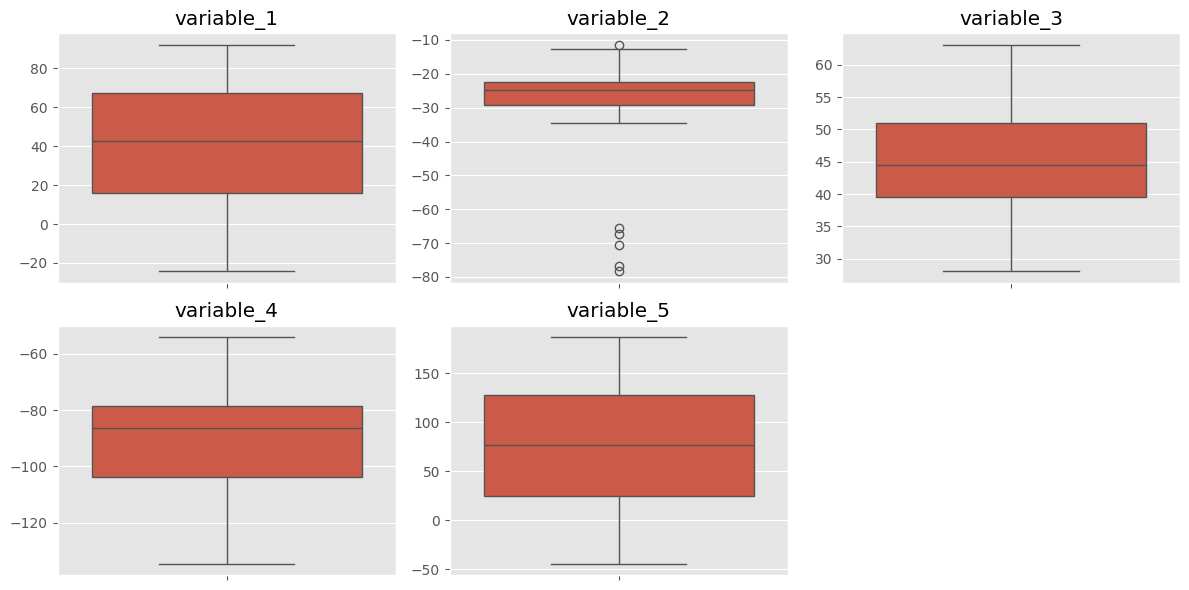

In [150]:

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
flattened_axes = fig.axes
flattened_axes[-1].set_visible(False)

for i, var in enumerate(variables):
    sns.boxplot(data=data_multivariada[:,i], ax=flattened_axes[i])
    flattened_axes[i].set_title(var)

plt.tight_layout()
plt.show()

Mediante los boxplots se evidencia que la variable 2 tiene outliers (valores por fuera de las barras de q1 - 1.5 * iqr y q3 + 1.5 * iqr)

generamos histogramas para entender las distribuciones de las variables, vemos que las variables 1, 5 y 6 tienen distribuciones bimodales

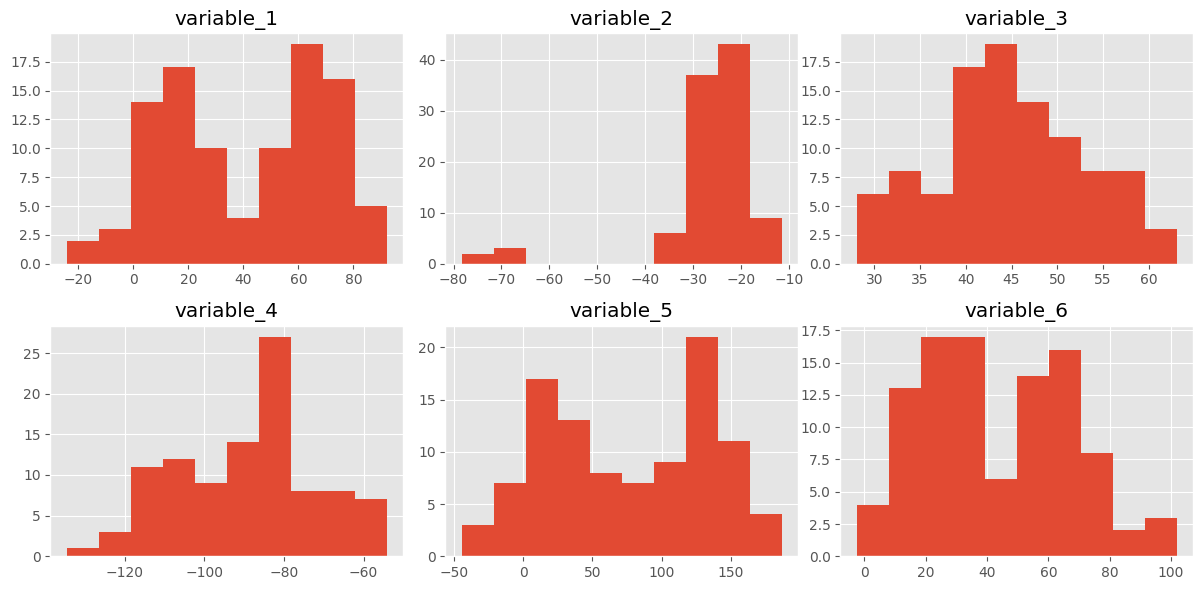

In [153]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
row = 0
col = 0
for i,var in enumerate(variables):
    axes[row, col].hist(data_multivariada[:,i])
    axes[row, col].set_title(var)
    col += 1
    if col == n_cols:
        col = 0
        row += 1
plt.tight_layout()
plt.show()

In [376]:

def iqr_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    data_without_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
    return data_without_outliers,outliers, lower_bound, upper_bound

list_sin_outliers = []
list_outliers = []
list_lower_bound = []
list_upper_bound = []
for i, var in enumerate(variables):
    data_without_outliers,outliers, lower_bound, upper_bound = iqr_outliers(data_multivariada[:,i])
    list_sin_outliers.append(data_without_outliers)
    list_outliers.append(outliers)
    list_lower_bound.append(lower_bound)
    list_upper_bound.append(upper_bound)
    str_outliers = ''
    if len(outliers) > 0:
        str_outliers = f'para la  {var} se encontraron {len(outliers)} outliers'
    else:
        str_outliers = f'para la  {var} no se encontraron outliers'


    print(f'{str_outliers}, el conjunto de  datos resultantes (sin outliers) tiene {len(data_without_outliers)} datos, que son:: ')
    print(list(data_without_outliers))
    print()



para la  variable_1 no se encontraron outliers, el conjunto de  datos resultantes (sin outliers) tiene 100 datos, que son:: 
[75.9605698361348, 68.34082838594578, 77.77226245720831, 88.2763582768963, 67.19015950331996, 67.19035651660984, 88.9505537860887, 79.20921674983491, 64.36630736878058, 76.51072052303158, 64.43898768625046, 64.41124295715692, 72.90354725879241, 47.04063706410643, 49.300986009843605, 63.25254964910833, 57.84602655598691, 73.77096799114328, 59.10371109374547, 53.05235558397651, 87.58778522705865, 67.29068439416157, 70.81033845625508, 52.90302176543852, 63.467407305697805, 71.3310710765184, 56.188077070932366, 74.50837622014807, 62.79233572097434, 66.49967500248067, 62.77952065324724, 92.22733821410723, 69.8380333031448, 57.3074688525292, 79.87053894523827, 55.34987620034774, 72.50636314005706, 46.48395851344269, 54.06176741321883, 72.36233483042949, 78.86159895994493, 72.05641937427964, 68.61222061134112, 66.38675565292853, 52.25773611559087, 61.3618694992635, 64.4

Encontramos outliers en la variable 2 lo que es consistente con los resultados encontrados mediante el análisis de los boxplots realizado anteriormente

In [377]:
list_outliers


[array([], dtype=float64),
 array([-76.8982671 , -67.19000245, -65.64794905, -78.33104043,
        -11.39915417, -70.6642131 ]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

Para la variable 2 que fue donde encontramos outliers, eliminamos los valores -76.8982671 , -67.19000245, -65.64794905, -78.33104043,
        -11.39915417 y -70.6642131. Para limpiar el dataset imputamos estos datos con la mediana de la variable

In [380]:
data_multivariada_limpia = datos_multivariados.copy()

In [381]:

var_1 = data_multivariada_limpia['variable_1']
var_2 = data_multivariada_limpia['variable_2']

q1 = np.percentile(var_2, 25)
q3 = np.percentile(var_2, 75)
median = np.median(var_2)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [382]:
lower_bound,upper_bound

(-39.65358682816273, -11.90248432180044)

In [384]:
data_multivariada_limpia.loc[data_multivariada_limpia['variable_2']  < lower_bound, 'variable_2'] = np.nan
data_multivariada_limpia['variable_2'].fillna(median, inplace=True)

In [387]:
data_multivariada_limpia

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6
0,75.960570,-32.076854,46.057660,-87.460649,158.453592,72.584991
1,68.340828,-24.678017,44.191455,-90.998849,141.947455,68.463546
2,77.772262,-26.713573,50.975312,-97.204909,152.205406,61.811276
3,88.276358,-29.011386,55.498851,-112.193825,161.348884,66.322541
4,67.190160,-25.806429,44.058451,-83.847028,126.689375,66.830084
...,...,...,...,...,...,...
95,-6.952724,-23.073413,56.422878,-111.634088,-22.724551,13.200723
96,19.441804,-29.419287,40.483857,-70.730719,29.749096,-2.571916
97,18.915829,-24.231374,40.736677,-80.899047,24.545820,24.985839
98,15.076702,-24.708956,46.092984,-84.429655,19.701712,52.079287


Calculamos la matriz de correlaciones de Pearson y la visualizamos mediante un mapa de calor.

Observamos que efectivamente las variables 1, 5 y 6 están altamente relacionadas entre si y que las variables 3 y 4 están relacionadas entre si

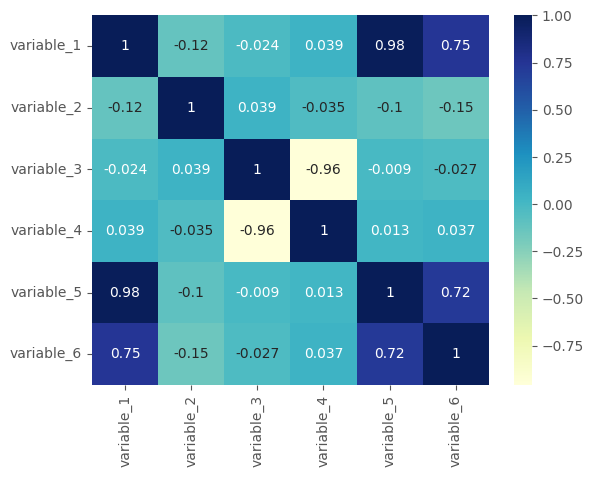

In [388]:
corr = data_multivariada_limpia.corr(method = 'pearson',numeric_only=True)
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

Escogemos un umbral de 0.7 para las correlaciones, ahora pasamos por cada par de variables y comparamos su correlación absoluta con el umbral

In [260]:
umbral = 0.7
#corr_values = corr.values
corr_values = np.corrcoef(data_multivariada_limpia, rowvar = False).round(decimals=2)
pairs_i, pairs_j = np.where(np.abs(corr_values) > umbral)
list_pairs = list(zip(pairs_i, pairs_j))
indexes = set()
for pair in list_pairs:
  if pair[0] != pair[1]:
    indexes.add((min(pair),max(pair)))

final_pairs = []
print('las parejas de variables cuya correlacion excede el umbral son')
for pair in indexes:
  if pair[0] != pair[1]:
    print(corr.columns[pair[0]],'y ', corr.columns[pair[1]])
    final_pairs.append((corr.columns[pair[0]], corr.columns[pair[1]]))


las parejas de variables cuya correlacion excede el umbral son
variable_3 y  variable_4
variable_5 y  variable_6
variable_1 y  variable_5
variable_1 y  variable_6


Vemos que las variables 1,5 y 6 están relacionadas entre sí y que sus correlaciones absolutas están por encima del umbral. Pasa lo mismo con las variables 3 y 4

In [261]:
data_multivariada_limpia.describe()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,41.280513,-24.733630,44.952229,-89.054627,76.485175,43.493526
std,28.823874,4.664445,8.179224,17.643321,59.070311,23.907536
min,-24.296177,-34.593856,28.040307,-134.618607,-44.486712,-2.571916
25%,15.998455,-28.805577,39.561756,-103.763842,24.468778,24.482930
50%,42.476807,-24.667601,44.527476,-86.453579,76.967232,38.230766
75%,67.190209,-22.309148,51.030509,-78.571991,127.617104,64.336689
max,92.227338,-11.399154,63.112288,-54.095020,186.928357,101.972884


In [270]:
data_multivariada_limpia.var()

,0
variable_1,830.815711
variable_2,129.091432
variable_3,66.899712
variable_4,311.286774
variable_5,3489.301685
variable_6,571.570281


Vemos que de las variables 1, 5 y 6 la que mayor varianza tiene es la variable 5 así que eliminamos las variables 1 y 6. Similarmente observamos que la variable 4 tiene más varianza que la 3 por lo que eliminamos la 3

In [271]:
datos_finales = data_multivariada_limpia.drop(columns=['variable_1','variable_6','variable_3'])

Finalmente obtenemos un dataset limpio con las variables seleccionadas

In [272]:
datos_finales.to_csv('datos_finales_punto4.csv', index=False)

,variable_2,variable_4,variable_5
0,-32.076854,-87.460649,158.453592
1,-76.898267,-90.998849,141.947455
2,-26.713573,-97.204909,152.205406
3,-29.011386,-112.193825,161.348884
4,-25.806429,-83.847028,126.689375
...,...,...,...
95,-23.073413,-111.634088,-22.724551
96,-29.419287,-70.730719,29.749096
97,-24.231374,-80.899047,24.545820
98,-24.708956,-84.429655,19.701712


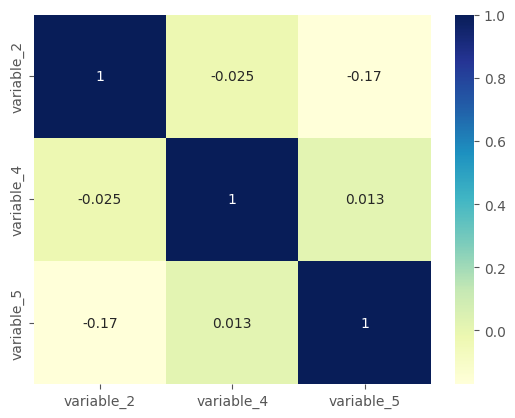

In [389]:
corr_final = datos_finales.corr(method = 'pearson',numeric_only=True)
dataplot_final = sns.heatmap(corr_final, cmap="YlGnBu", annot=True)

Verificamos que las variables seleccionadas no tienen correlaciones  absolutas altas